In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np

In [1]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
dt_unclean = pd.read_excel("for_textclassification_data.xlsx")

In [5]:
dt_unclean.shape[0]

14136

In [6]:
df = dt_unclean.dropna(subset=["Comment"])

In [7]:
df.shape[0]

1785

In [8]:
labels = df["channels"].unique()

In [9]:
labels

array(['vickers', 'ib or mb', 'pweb', 'cctr', 'sweb',
       'chatbot or live agent', 'internet banking', 'rewards redemption',
       'mobile banking', 'cctr or chatbot', '0', 'channels'], dtype=object)

In [12]:
print("No. of reviews for vickers: ", len(df.loc[df.channels == 'vickers']))
print("No. of reviews for ib/mb: ", len(df.loc[df.channels == 'ib or mb']))
print("No. of reviews for pweb: ", len(df.loc[df.channels == 'pweb']))
print("No. of reviews for cctr: ", len(df.loc[df.channels == 'cctr']))
print("No. of reviews for sweb: ", len(df.loc[df.channels == 'sweb']))
print("No. of reviews for chatbot or live agent: ", len(df.loc[df.channels == 'chatbot or live agent']))
print("No. of reviews for internet banking: ", len(df.loc[df.channels == 'internet banking']))
print("No. of reviews for rewards redemption: ", len(df.loc[df.channels == 'rewards redemption']))
print("No. of reviews for mobile banking: ", len(df.loc[df.channels == 'mobile banking']))
print("No. of reviews for cctr or chatbot: ", len(df.loc[df.channels == 'cctr or chatbot']))
print("No. of reviews for 0: ", len(df.loc[df.channels == '0']))
print("No. of reviews for channels: ", len(df.loc[df.channels == 'channels']))


No. of reviews for vickers:  25
No. of reviews for ib/mb:  269
No. of reviews for pweb:  441
No. of reviews for cctr:  43
No. of reviews for sweb:  17
No. of reviews for chatbot or live agent:  123
No. of reviews for internet banking:  27
No. of reviews for rewards redemption:  3
No. of reviews for mobile banking:  192
No. of reviews for cctr or chatbot:  37
No. of reviews for 0:  607
No. of reviews for channels:  1


In [13]:
reviews = list(df.Comment)

In [15]:
len(reviews)

1785

In [16]:
# Create a mapping from unique labels to integers
label_mapping = {label: idx for idx, label in enumerate(np.unique(df["channels"]))}

# Map the labels in the DataFrame to integers using the mapping
labels_encoded = df["channels"].map(label_mapping).values

In [30]:
labels_encoded

array([11, 11,  5, ...,  0,  8,  8], dtype=int64)

In [17]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [18]:
max_len = 0

# For every review...
for review in reviews:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(review, add_special_tokens=True)

    # Update the maximum review length.
    max_len = max(max_len, len(input_ids))

print('Max review length: ', max_len)

Max review length:  131


In [19]:
encoded_reviews = tokenizer(reviews,
                          max_length = 128,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt'     # Return pytorch tensors.
)

In [31]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
#dataset = TensorDataset(input_ids, attention_masks, labels)
dataset = TensorDataset(encoded_reviews['input_ids'], encoded_reviews['attention_mask'], torch.tensor(labels_encoded))

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,606 training samples
  179 validation samples


In [32]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [34]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 12, 
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
# model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [35]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

C:\Users\Xavior\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [41]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

255


In [42]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [43]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [44]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

In [47]:
# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()


# For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = outputs.loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        # Accumulate the validation loss.
        loss = outputs.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    10  of     51.    Elapsed: 0:02:47.
  Batch    20  of     51.    Elapsed: 0:05:39.
  Batch    30  of     51.    Elapsed: 0:08:31.
  Batch    40  of     51.    Elapsed: 0:11:24.
  Batch    50  of     51.    Elapsed: 0:14:16.

  Average training loss: 0.87
  Training epoch took: 0:14:19

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.82
  Validation took: 0:00:34

======== Epoch 2 / 5 ========
Training...
  Batch    10  of     51.    Elapsed: 0:02:52.
  Batch    20  of     51.    Elapsed: 0:05:44.
  Batch    30  of     51.    Elapsed: 0:08:35.
  Batch    40  of     51.    Elapsed: 0:11:03.
  Batch    50  of     51.    Elapsed: 0:13:29.

  Average training loss: 0.66
  Training epoch took: 0:13:32

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.79
  Validation took: 0:00:30

======== Epoch 3 / 5 ========
Training...
  Batch    10  of     51.    Elapsed: 0:02:34.
  Batch    20  of     51.    Elapsed: 0:05:24.
 

In [48]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.8657965987336402,
  'Valid. Loss': 0.8222741037607193,
  'Valid. Accur.': 0.7875548245614036,
  'Training Time': '0:14:19',
  'Validation Time': '0:00:34'},
 {'epoch': 2,
  'Training Loss': 0.6550304714371177,
  'Valid. Loss': 0.7853141129016876,
  'Valid. Accur.': 0.7927631578947368,
  'Training Time': '0:13:32',
  'Validation Time': '0:00:30'},
 {'epoch': 3,
  'Training Loss': 0.5352359308915979,
  'Valid. Loss': 0.7634687423706055,
  'Valid. Accur.': 0.7875548245614036,
  'Training Time': '0:13:43',
  'Validation Time': '0:00:29'},
 {'epoch': 4,
  'Training Loss': 0.44953692996618794,
  'Valid. Loss': 0.7855844497680664,
  'Valid. Accur.': 0.7771381578947368,
  'Training Time': '0:13:39',
  'Validation Time': '0:00:34'},
 {'epoch': 5,
  'Training Loss': 0.4122834997434242,
  'Valid. Loss': 0.7876992225646973,
  'Valid. Accur.': 0.7771381578947368,
  'Training Time': '0:13:00',
  'Validation Time': '0:00:30'}]

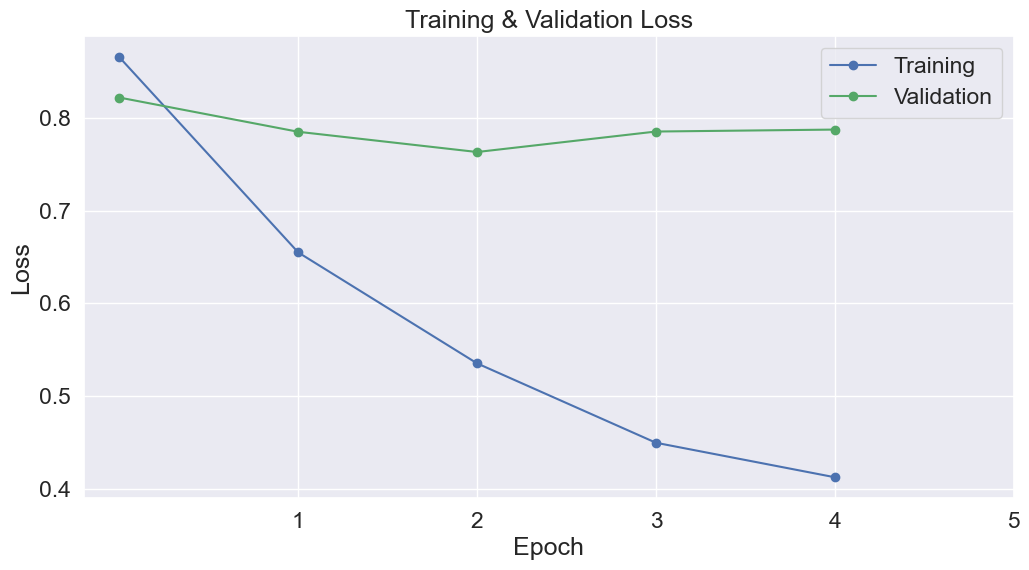

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

df_stats = pd.DataFrame(data=training_stats)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

In [60]:
# Load the dataset into a pandas dataframe.
df_test = pd.read_excel("for_textclassification_data_test.xlsx")

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Create sentence and label lists
sentences_test = df_test.Comment.values
labels_test = df_test["channels"].map(label_mapping).values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_test:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 107



In [61]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,  #pass ID and mask, not labels, labels only pass during training
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 107 test sentences...
    DONE.


In [62]:
predictions[0]

array([[-1.45104742e+00, -8.10069561e-01, -8.92128229e-01,
        -4.37359780e-01, -7.41080701e-01,  6.02828145e-01,
        -1.15123257e-01,  4.47845936e+00, -6.26573920e-01,
        -6.99770629e-01, -1.28062177e+00, -3.73583660e-02],
       [-1.15062833e+00,  5.58616184e-02, -1.83272541e-01,
        -1.55829704e+00, -1.38057828e-01,  2.04449153e+00,
        -1.86923593e-01, -5.83616495e-01,  2.60208702e+00,
        -1.04350793e+00,  5.96553609e-02, -2.33675897e-01],
       [-1.61928773e+00, -7.55871534e-01, -9.48701859e-01,
        -4.95131284e-01, -2.72451580e-01,  4.26383317e-01,
         1.54067669e-02,  4.62407732e+00, -1.23817062e+00,
        -4.45187896e-01, -1.09548891e+00,  1.09713525e-01],
       [-2.37953973e+00, -1.00018752e+00, -1.15986204e+00,
        -5.66239297e-01, -7.50553191e-01,  3.62578893e+00,
         2.96393514e-01,  2.60880947e+00, -1.16108906e+00,
        -6.27164006e-01, -7.94132411e-01,  4.69127953e-01],
       [-1.54492176e+00,  1.09305620e+00,  1.0071013

In [65]:
total_test_accuracy = 0
for p, t in zip(predictions, true_labels):
  print("Accuracy for batch: ", flat_accuracy(p, t))
  total_test_accuracy += flat_accuracy(p, t)

print("Overall accuracy for test set:", total_test_accuracy/len(predictions))

Accuracy for batch:  0.8125
Accuracy for batch:  0.84375
Accuracy for batch:  1.0
Accuracy for batch:  0.9090909090909091
Overall accuracy for test set: 0.8913352272727273


In [63]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
pred_labels = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch, convert the predicted logits to 0/1 labels...
for i in range(len(predictions)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels.append(np.argmax(predictions[i], axis=1).flatten())


# For each input batch...
for i in range(len(true_labels)):

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels[i])
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


C:\Users\Xavior\AppData\Local\Temp\ipykernel_58148\2646804597.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


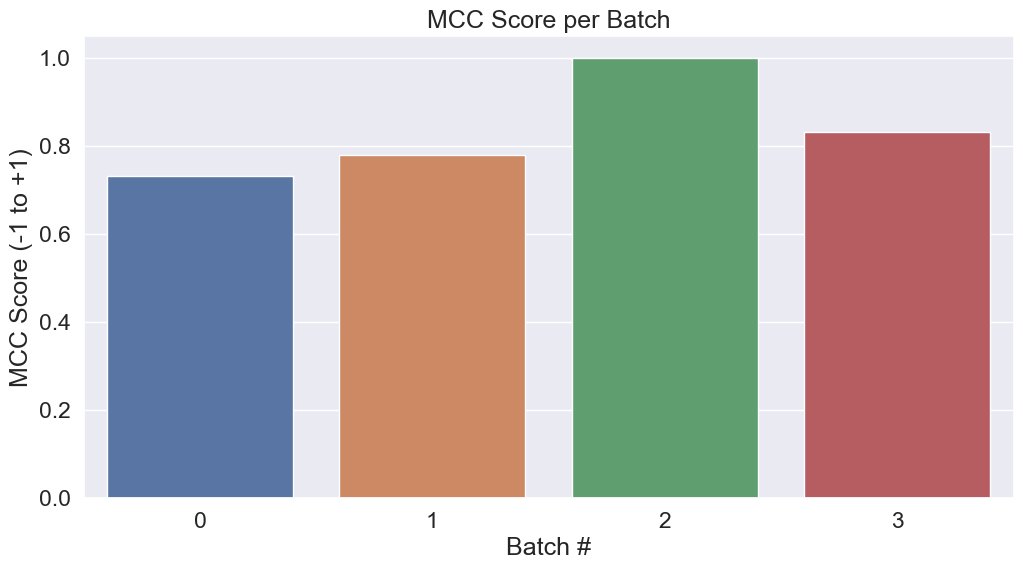

In [64]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [74]:
pred_labels[2]

array([8, 5, 0, 8, 8, 8, 8, 8, 0, 8, 0, 7, 8, 0, 0, 8, 8, 0, 0, 0, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 0, 8], dtype=int64)

In [75]:
true_labels[2]

array([8, 5, 0, 8, 8, 8, 8, 8, 0, 8, 0, 7, 8, 0, 0, 8, 8, 0, 0, 0, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 0, 8], dtype=int64)

In [69]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_pred_labels = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_pred_labels)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.863


In [70]:
#Saving your model.
output_file = "./model_bert_channels.pth"

def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_file)

save(model, optimizer)


In [ ]:
# #In the future, if you want to continue to work on this model, you can load it back in.
# checkpoint = torch.load(output_file, map_location='cpu')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])